# Training

This notebook demonstrates the process of training an ensemble learning model using a provided CSV file. It showcases data preprocessing, model training, evaluation, and saving the trained model. The ensemble method (hard voting, soft voting, or stacking) can be selected based on the user's choice.


## Importing Necessary Libraries

First, we import all the necessary libraries and modules needed for this script. This includes libraries for handling warnings, data manipulation, machine learning, and the custom Ensemble module containing ensemble learning methods.

In [1]:
import pandas as pd
import os
import math
import numpy as np
from src import Utils, Bayes

import sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, tokenized_text, TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt 
import joblib

pd.set_option('max_colwidth', 800)

/tmp/ipykernel_27884/1069041386.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Settings

In [2]:
TEST_SIZE = 0.2

SAVE_MODEL = False
MODEL_FOLDER = 'models/model_bayes/revised-1'
DATASET_TRAIN = 'datasets/dataset-train.csv'
DATASET_TEST = 'datasets/dataset-test.csv'

## Utility Functions

### Model saving folder creation

Create a folder to save the model based on `MODEL_FOLDER`

In [3]:
if SAVE_MODEL:
  os.makedirs(
    MODEL_FOLDER,
    exist_ok=True, # Create folder if it doesn't exist, else do nothing
  )

  print(f"Saving model at '{MODEL_FOLDER}'")

### Function to Read CSV File

The `read_csv_file` function reads the CSV file and returns a pandas DataFrame. If the file is not found, the script will exit with an error message.

In [4]:
def read_csv_file(filename: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(filename, lineterminator='\n', usecols=range(2))
        print("CSV file read successfully!")
        return data
    except FileNotFoundError:
        print("ERROR: File not found")
        exit(1)

dataset_train = read_csv_file(DATASET_TRAIN)
dataset_test = read_csv_file(DATASET_TEST)

CSV file read successfully!
CSV file read successfully!


In [5]:
X_train = dataset_train['text']
y_train = dataset_train['label']

X_test = dataset_test['text']
y_test = dataset_test['label']

## Train Data

In [6]:
pd.DataFrame({
  'text': X_train,
  'label': y_train,
})

,text,label
0,Matthew Chang [USERNAME] Remind ko lang di ba galit na galit ka dun sa taong di marunong magbayad ng utang? Tapos kay marcos hindi iboboto mo pa? Well Marcos Magnanakaw Never Again,1
1,Yay! The interview served its purpose wellJessica Soho Interviews Angat Buhay LahatKakampink,0
2,I say DASURV,0
3,TayNew said Let Leni Lead,0
4,Gloc 9 is not endorsing Jejomar Binay as his presidential bet 2016 Elections 2016 Polls,0
...,...,...
22764,Nov. 11: on [USERNAME] saw tv ads of Jojo BinayFrancis TolentinoAlan CayetanoMartin RomualdezMar RoxasRisa Hontiveros epal watch,1
22765,Mar Roxas your call for unity describes one thing! SELFISHNESS! You don't deserve to be the PRESIDENT!!!,1
22766,Buti nalang nagdecide nakong hindi manood ng TV. Hindi ko pa napapakinggan yung Only Binay na yan.,0
22767,sang boto para sa pagbabago. Let Leni Lead philippine elections para sa pagbabago laban para sa bayan ofw dubai election,0


In [7]:
y_train.value_counts(ascending=True)

label
0    11292
1    11477
Name: count, dtype: int64

## Test Data

In [8]:
pd.DataFrame({
  'text': X_test,
  'label': y_test,
})

,text,label
0,Hindi susuportahan ng theatre and literary establishmentmafiasi Ka Leody de Guzman dahil at huwag na tayong maglokohan dito mga middle class matapobre from the centre centre left to the far left ang mga espasyo na ito sa PILI pinas PH Literary Mafia,0
1,BABAE LABAN SA FAKE AT FRAUDBFFSUMBONGDAYA DESKS The Sumbong Daya booth is our way of encouraging people to get involved in monitoring the elections one expression of peoples vigilance of beingmapagbantay eleksyon,1
2,Im proud to be a Filipino and a kakampink like BroArminAnimo La Salle! LSA NY here,0
3,Grabe noThe hypocrisy of the church to preach the Word of the Lord but then endorse politicians who clearly apparently definitely certainly evidently violated even just the Ten CommandmentsLike how can u do that?Yikes Halalan2022,1
4,BBMSARAUniteam Ph Arena BBMSARA,0
...,...,...
5687,[USERNAME] Rizalito David is a good man you can feel the sincerity everytime he talked And this is my first time i saw him not even before This is the kind of candidate we need,0
5688,A very famous religious cult in the Philippines will vote for Duterte and Marcos. ?? If only I have the means to get out of this country. ??,1
5689,Tama sir VP Leni Di dapat iboto SI BBM Kase No1 SINUNGALING Angat Buhay Lahat,0
5690,RT [USERNAME]: Mar Roxas forever arrogantI can't imagine him as a president plus the irritating first lady on his side.,1


In [9]:
y_test.value_counts(ascending=True)

label
0    2823
1    2869
Name: count, dtype: int64

## TfidfVectorizer

In [10]:
tfidf = TfidfVectorizer()
tfidf

TfidfVectorizer()

In [11]:
X_train_transformed = tfidf.fit_transform(X_train)

  (0, 21543)	1.0
  (0, 5740)	1.0
  (0, 37801)	1.0
  (0, 31198)	1.0
  (0, 17072)	1.0
  (0, 17830)	1.0
  (0, 7901)	2.0
  (0, 2728)	1.0
  (0, 11007)	2.0
  (0, 22826)	1.0
  (0, 15550)	1.0
  (0, 8742)	1.0
  (0, 32107)	1.0
  (0, 35496)	1.0
  (0, 21302)	1.0
  (0, 19378)	1.0
  (0, 25135)	1.0
  (0, 37825)	1.0
  (0, 35527)	1.0
  (0, 16597)	1.0
  (0, 21092)	2.0
  (0, 12914)	1.0
  (0, 13471)	1.0
  (0, 22312)	1.0
  (0, 26607)	1.0
  :	:
  (22766, 24567)	1.0
  (22766, 23121)	1.0
  (22767, 32107)	3.0
  (22767, 18367)	1.0
  (22767, 18185)	1.0
  (22767, 18050)	1.0
  (22767, 9240)	1.0
  (22767, 3287)	1.0
  (22767, 27770)	3.0
  (22767, 9220)	1.0
  (22767, 4625)	1.0
  (22767, 17533)	1.0
  (22767, 28439)	1.0
  (22767, 26752)	2.0
  (22767, 26053)	1.0
  (22767, 32451)	1.0
  (22767, 8650)	1.0
  (22768, 25135)	1.0
  (22768, 3873)	1.0
  (22768, 25262)	1.0
  (22768, 37165)	1.0
  (22768, 39570)	1.0
  (22768, 834)	1.0
  (22768, 8673)	1.0
  (22768, 23810)	1.0


In [12]:
tokenized_text = tfidf.get_tokenized_text()

In [13]:
for text in tokenized_text[:5]:
  for token in text:
    print(token, end=' ')
  print()

matthew chang username remind ko lang di ba galit na galit ka dun sa taong di marunong magbayad ng utang tapos kay marcos hindi iboboto mo pa well marcos magnanakaw never again 
yay the interview served its purpose welljessica soho interviews angat buhay lahatkakampink 
say dasurv 
taynew said let leni lead 
gloc is not endorsing jejomar binay as his presidential bet 2016 elections 2016 polls 


In [14]:
length_of_first_sample = len(tokenized_text[0])
length_of_first_sample

32

In [15]:
unique_tokens_in_first_sample = len(set(tokenized_text[0]))
unique_tokens_in_first_sample

29

In [16]:
from collections import Counter

word_count_in_first_sample = Counter(tokenized_text[0])
word_count_in_first_sample


Counter({'matthew': 1,
         'chang': 1,
         'username': 1,
         'remind': 1,
         'ko': 1,
         'lang': 1,
         'di': 2,
         'ba': 1,
         'galit': 2,
         'na': 1,
         'ka': 1,
         'dun': 1,
         'sa': 1,
         'taong': 1,
         'marunong': 1,
         'magbayad': 1,
         'ng': 1,
         'utang': 1,
         'tapos': 1,
         'kay': 1,
         'marcos': 2,
         'hindi': 1,
         'iboboto': 1,
         'mo': 1,
         'pa': 1,
         'well': 1,
         'magnanakaw': 1,
         'never': 1,
         'again': 1})

In [17]:
indices_of_first_sample = list(tfidf.vocabulary_.values())[:unique_tokens_in_first_sample]

In [18]:
transformed_values_of_first_sample = X_train_transformed[0,:]
transformed_indices = transformed_values_of_first_sample.toarray()[0][indices_of_first_sample]

In [19]:
idf_of_first_sample = tfidf.idf_[indices_of_first_sample]

pd.DataFrame({
  'Token': word_count_in_first_sample.keys(),
  'Index': indices_of_first_sample,
  'Word Count': word_count_in_first_sample.values(),
  'TF': np.array(list(word_count_in_first_sample.values())) / length_of_first_sample,
  'IDF': idf_of_first_sample,
  'TF-IDF': transformed_indices,
})

,Token,Index,Word Count,TF,IDF,TF-IDF
0,matthew,21543,1,0.03125,9.241440,0.279254
1,chang,5740,1,0.03125,9.646905,0.291506
2,username,37801,1,0.03125,2.187134,0.066090
3,remind,31198,1,0.03125,8.394142,0.253651
4,ko,17072,1,0.03125,3.594228,0.108609
5,lang,17830,1,0.03125,3.423833,0.103460
6,di,7901,2,0.06250,4.073801,0.246201
7,ba,2728,1,0.03125,4.118468,0.124450
8,galit,11007,2,0.06250,6.843544,0.413591
9,na,22826,1,0.03125,2.456983,0.074244


In [20]:
print(X_train_transformed[:20])

  (0, 1010)	0.14154114290502026
  (0, 25065)	0.13484056819880236
  (0, 19612)	0.10515466975097663
  (0, 38691)	0.18654504544666467
  (0, 26607)	0.10602268230271318
  (0, 22312)	0.11253001200396257
  (0, 13471)	0.18428895185804584
  (0, 12914)	0.11680287938523953
  (0, 21092)	0.19740315706525552
  (0, 16597)	0.11593027353784696
  (0, 35527)	0.16014908327853106
  (0, 37825)	0.21122562182827861
  (0, 25135)	0.0824698997175756
  (0, 19378)	0.25156617468210496
  (0, 21302)	0.22596285123042645
  (0, 35496)	0.20098259353198072
  (0, 32107)	0.07162105948607582
  (0, 8742)	0.19163564209743453
  (0, 15550)	0.10730518761249495
  (0, 22826)	0.07424416354646084
  (0, 11007)	0.41359122796583175
  (0, 2728)	0.12445030263663033
  (0, 7901)	0.24620110711286955
  (0, 17830)	0.10346006775287145
  (0, 17072)	0.10860899720215379
  :	:
  (18, 20340)	0.22606670142469276
  (18, 37364)	0.3321944874652387
  (18, 35293)	0.2589027133825387
  (18, 2675)	0.20470675383495324
  (18, 39570)	0.14725301970957752
  (18, 

In [21]:
X_train_transformed.shape

(22769, 39663)

## Bernoulli Naive Bayes

In [22]:
bayes = BernoulliNB()
bayes

BernoulliNB()

In [23]:
bayes.fit(X_train_transformed, y_train)

BernoulliNB()

## Results

In [24]:
X_test_transformed = tfidf.transform(X_test)

In [25]:
print(X_test_transformed)

  (0, 36420)	0.06932671158019985
  (0, 35922)	0.13366727539468312
  (0, 35683)	0.15714039537990382
  (0, 35017)	0.20961838615698605
  (0, 32107)	0.058120655879867054
  (0, 28872)	0.12302623547885334
  (0, 28585)	0.12910359147160638
  (0, 28402)	0.12174452645604648
  (0, 25135)	0.06692451488886765
  (0, 22826)	0.12049862181699064
  (0, 22021)	0.20583835444944304
  (0, 21967)	0.15514443383836807
  (0, 21468)	0.23108633939513457
  (0, 19584)	0.23655819135353445
  (0, 19314)	0.22661551081090742
  (0, 18333)	0.11260969154431087
  (0, 18140)	0.35897892279803467
  (0, 15550)	0.0870784086147579
  (0, 14941)	0.12964595693670605
  (0, 13340)	0.16309784077944908
  (0, 12914)	0.09478580751583185
  (0, 11900)	0.115468613366716
  (0, 10783)	0.11604666674618455
  (0, 10143)	0.18408020057645222
  (0, 8293)	0.13410112172771607
  :	:
  (5689, 4885)	0.1834887118355732
  (5689, 3338)	0.1982656239149944
  (5689, 1773)	0.19589663436166543
  (5690, 37801)	0.08960026415650933
  (5690, 35922)	0.111655213415242

In [26]:
y_preds = bayes.predict(X_test_transformed)

In [27]:
accuracy = accuracy_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1: {f1}")

if SAVE_MODEL:
  pd.DataFrame([{
    'accuracy': accuracy,
    'recall': recall,
    'precision': precision,
    'f1': f1,
  }]).to_csv(f'{MODEL_FOLDER}/bayes_results.csv', index=False)

Accuracy: 0.8185172171468728
Recall: 0.8717323109097247
Precision: 0.7899557801642451
F1: 0.8288318144159071


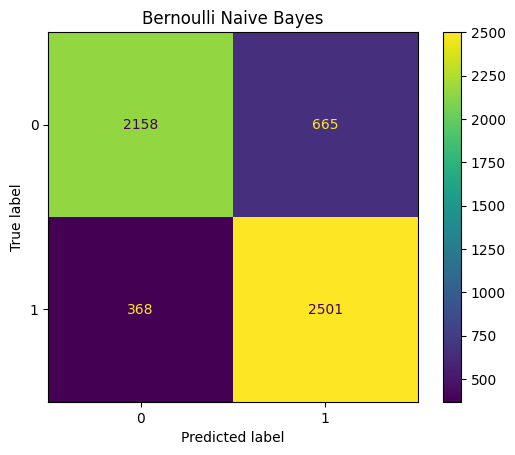

In [28]:
conf_matrix = confusion_matrix(y_test, y_preds)

conf_matrix_display = ConfusionMatrixDisplay(conf_matrix)

conf_matrix_display.plot()
if SAVE_MODEL:
  conf_matrix_display.figure_.savefig(f'{MODEL_FOLDER}/conf_matrix.png')

plt.title("Bernoulli Naive Bayes")
plt.show()

In [29]:
if SAVE_MODEL:
  joblib.dump(tfidf, f'{MODEL_FOLDER}/tfidf.pkl', compress=True)
  joblib.dump(bayes, f'{MODEL_FOLDER}/bayes.pkl', compress=True)
  print(f"Saved model to {MODEL_FOLDER}/bayes.pkl")